# Simulation of outliers

- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT, optimize_T_and_D_UOT_new

# for simulations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import seaborn as sns
from matplotlib.lines import Line2D

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


In [3]:
## functions for generating gaussian mixtures
from scipy.spatial.distance import cdist

def generate_perturbed_gmm_params(template_means, template_covs, 
                                   n_mixtures, mean_perturb=0.5, cov_perturb=0.3,
                                   weights=None, weight_perturb=0.0):
    """
    Generate GMM parameters for multiple mixtures by perturbing template means/covs and optionally weights.

    Parameters:
    - template_means: list of mean vectors for components
    - template_covs: list of covariance matrices for components
    - n_mixtures: number of mixtures to generate
    - mean_perturb: std deviation for Gaussian noise added to means
    - cov_perturb: scaling factor for covariance noise
    - weights: base weight vector (array-like of shape (n_components,)) or None for uniform
    - weight_perturb: std deviation for Gaussian noise added to weights (default: 0.0, no perturbation)

    Returns:
    - gmm_params: list of (means, covariances, weights) tuples
    """
    n_components = len(template_means)
    dim = template_means[0].shape[0]
    gmm_params = []

    # Handle default weights
    if weights is None:
        base_weights = np.ones(n_components) / n_components
    else:
        base_weights = np.asarray(weights)
        assert base_weights.shape == (n_components,), "weights must match number of components"
        assert np.isclose(base_weights.sum(), 1), "weights must sum to 1"

    for _ in range(n_mixtures):
        means = []
        covariances = []

        # Perturb weights if requested
        if weight_perturb > 0:
            noise = np.random.randn(n_components) * weight_perturb
            perturbed_weights = base_weights + noise
            min_val = perturbed_weights.min()
            if min_val < 0:
                perturbed_weights = perturbed_weights - min_val  # shift to make min = 0
            sum_val = perturbed_weights.sum()
            if sum_val > 0:
                perturbed_weights = perturbed_weights / sum_val
            else:
                # fallback to uniform if degenerate
                perturbed_weights = np.ones(n_components) / n_components
        else:
            perturbed_weights = base_weights.copy()

        for k in range(n_components):
            # Perturb means
            shift = np.random.randn(dim) * mean_perturb
            perturbed_mean = template_means[k] + shift

            # Perturb covariance
            noise = np.random.randn(dim, dim)
            noise = 0.5 * (noise + noise.T)  # Make symmetric
            perturbed_cov = template_covs[k] + cov_perturb * noise

            # Ensure positive-definite
            perturbed_cov = perturbed_cov @ perturbed_cov.T + 1e-3 * np.eye(dim)

            means.append(perturbed_mean)
            covariances.append(perturbed_cov)

        gmm_params.append((means, covariances, perturbed_weights))
    
    return gmm_params

def generate_inlier_outlier_means(n_components, dim, scale=4.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    assert n_components % 2 == 0, "n_components must be even for balanced inlier/outlier split."

    total_candidates = 2 * n_components
    raw_means = [np.random.randn(dim) * scale for _ in range(total_candidates)]
    mean_array = np.vstack(raw_means)

    # Compute average distances
    dists = cdist(mean_array, mean_array)
    np.fill_diagonal(dists, 0)
    avg_dists = dists.sum(axis=1) / (total_candidates - 1)

    # Select indices of k smallest and k largest
    k = n_components // 2
    inlier_indices = np.argsort(avg_dists)[:k]     # smallest avg distances
    outlier_indices = np.argsort(avg_dists)[-k:]   # largest avg distances

    selected_indices = list(inlier_indices) + list(outlier_indices)
    template_means = [raw_means[i] for i in selected_indices]
    
    return template_means

def sample_gmm(n_samples, means, covariances, weights):
    n_components = len(means)
    dim = means[0].shape[0]
    n_samples_per_component = np.random.multinomial(n_samples, weights)
    
    samples = []
    for k in range(n_components):
        data = np.random.multivariate_normal(means[k], covariances[k], n_samples_per_component[k])
        samples.append(data)
    
    return np.vstack(samples)

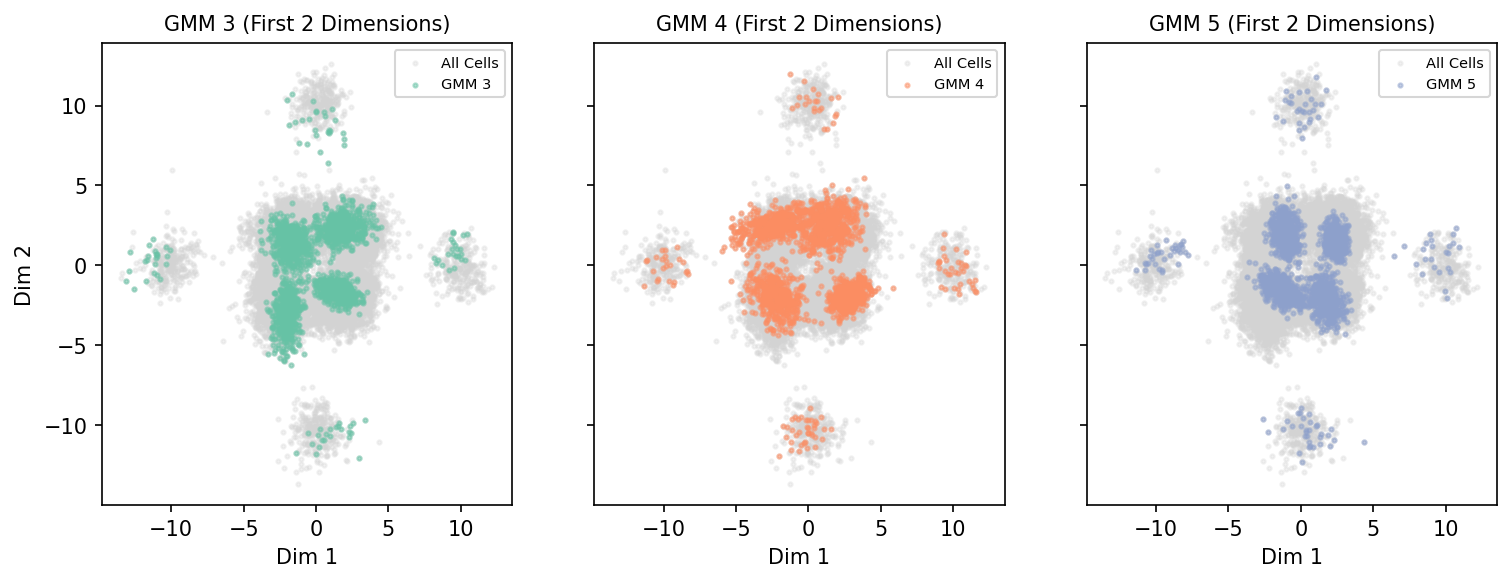

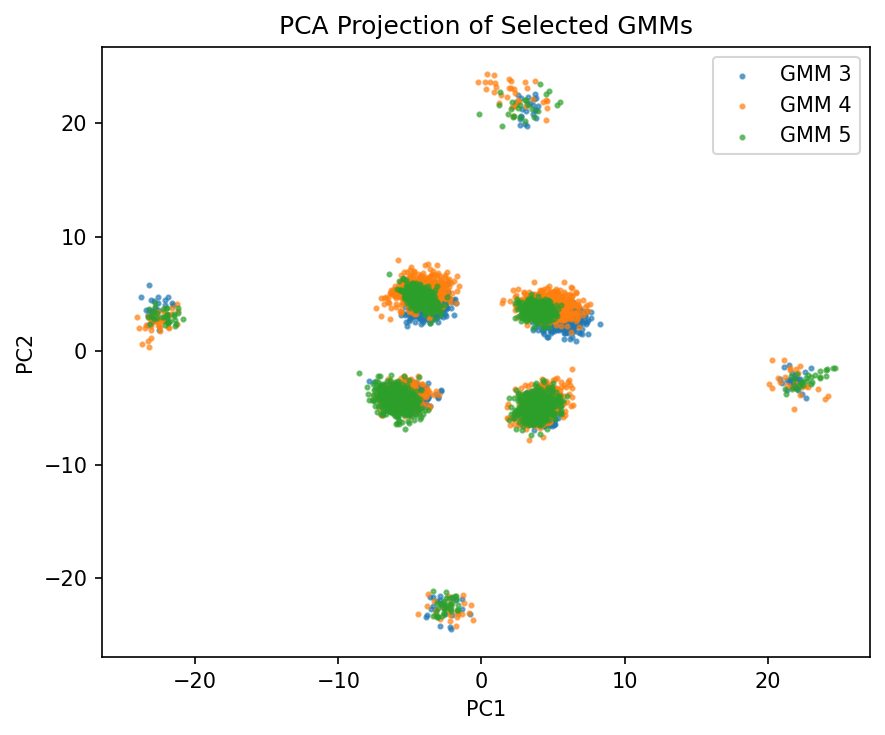

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# === Setup for 10D ===
seed = 25
np.random.seed(seed)
n_mixtures = 10
n_components = 8
dim = 10
samples_per_mixture = 2000

# Create symmetric central and outlier means in 10D (visible in first 2 dims)

template_means = [
    np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), np.array([2, 2, 2, 2, 2, -2, -2, -2, -2, -2]), 
    np.array([-2, -2, -2, -2, -2, 2, 2, 2, 2, 2]), np.array([-2, -2, -2, -2, -2, -2, -2, -2, -2, -2]), # close
    np.array([0, 0, 0, 0, 0, 10, 10, 10, 10, 10]), np.array([0, 0, 0, 0, 0, -10, -10, -10, -10, -10]), 
    np.array([10, 10, 10, 10, 10, 0, 0, 0, 0, 0]), np.array([-10, -10, -10, -10, -10, 0, 0, 0, 0, 0]), # close
]

template_covs = [np.eye(dim) * 0.5 for _ in range(n_components)]

# === Generate data ===
weights = [0.24, 0.24, 0.23, 0.23, 0.015, 0.015, 0.015, 0.015]
gmm_param_list = generate_perturbed_gmm_params(template_means, template_covs,
                                               n_mixtures=n_mixtures,
                                               weights=weights)

all_data = []
all_labels = []
for i, (means, covs, w) in enumerate(gmm_param_list):
    X = sample_gmm(samples_per_mixture, means, covs, w)
    all_data.append(X)
    all_labels.extend([i] * X.shape[0])

X_all = np.vstack(all_data)
labels_all = np.array(all_labels)

# === Visualization: First 2 dimensions ===
selected_indices = [3, 4, 5]
colors = sns.color_palette("Set2", len(selected_indices))
fig1, axes1 = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

for plot_i, ax in enumerate(axes1):
    i = selected_indices[plot_i]
    ax.scatter(X_all[:, 0], X_all[:, 5], color='lightgrey', alpha=0.3, s=4, label="All Cells")
    ax.scatter(all_data[i][:, 0], all_data[i][:, 5], color=colors[plot_i], alpha=0.5, s=4, label=f"GMM {i}")
    ax.set_title(f"GMM {i} (First 2 Dimensions)", fontsize=10)
    ax.set_xlabel("Dim 1")
    if plot_i == 0:
        ax.set_ylabel("Dim 2")
    else:
        ax.set_yticklabels([])
    ax.legend(fontsize=7)

# === Visualization: PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)
fig2, ax2 = plt.subplots(figsize=(6, 5), dpi=150)
for i in selected_indices:
    mask = labels_all == i
    ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], s=4, alpha=0.6, label=f"GMM {i}")
ax2.set_title("PCA Projection of Selected GMMs")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.legend()
plt.tight_layout()
plt.show()


In [5]:
## generating gaussian mixture datasets
gmm_samplers = []

for i in range(n_mixtures):
    X_i = all_data[i]  # shape (1000, 20)
    labels_i = np.full(X_i.shape[0], i)

    # Convert to pandas DataFrames
    X_df = pd.DataFrame(X_i, columns=[f"PC{j}" for j in range(dim)])
    meta_df = pd.DataFrame({'label': labels_i})

    # Construct dataset and sampler
    dataset = tensorDataset(X_df, meta_df)
    sampler = tensorSampler(dataset, device="cpu")
    gmm_samplers.append(sampler)

    print(f"Sampler {i}: {len(dataset)} samples")

Sampler 0: 2000 samples
Sampler 1: 2000 samples
Sampler 2: 2000 samples
Sampler 3: 2000 samples
Sampler 4: 2000 samples
Sampler 5: 2000 samples
Sampler 6: 2000 samples
Sampler 7: 2000 samples
Sampler 8: 2000 samples
Sampler 9: 2000 samples


In [6]:
# hyper parameters
ALPHAS_LF = len(gmm_samplers)*[1/len(gmm_samplers)]

DIM = dim
NUM = n_mixtures
device = "cpu"
bn = False

BATCH_SIZE = 64
G_ITERS, D_ITERS, T_ITERS = 50, 50, 10
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Parameters for T and D
input_size = DIM # DIM
n_outputs = NUM # number of distributions
output_size = DIM
n_hidden = 3
task_specific_hidden_size_T = 100
task_specific_hidden_size_D = 100
dropout_rate = 0.05

# paramerters for G
size=256
input_dim = DIM
num_layers = 4

In [7]:
# G with pretraining
Z_sampler = distributions.StandardNormalSampler(dim=input_dim, device=device)
# G without pretraining
G = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

In [8]:
# G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
G_opt = torch.optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-8)
loss = np.inf

G.train(True)

for iteration in tqdm(range(10000)):
    Z = Z_sampler.sample(BATCH_SIZE).detach() * 6
    loss = F.mse_loss(Z, G(Z))
    loss.backward()
    G_opt.step(); G_opt.zero_grad()
    if loss.item() < 1e-2:
        break

100%|██████████| 10000/10000 [00:18<00:00, 532.16it/s]


In [9]:
# T/D setup
D = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
D.apply(weights_init)
print(D)

# Seperate T
T = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
T.apply(weights_init)

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in D.parameters()]))

criterions = [nn.MSELoss() for _ in range(n_outputs)]
T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

print(n_outputs)

Seperate_D(
  (task_nets): ModuleList(
    (0-9): 10 x FFNN(
      (hidden): ModuleList(
        (0): Linear(in_features=10, out_features=100, bias=True)
        (1-2): 2 x Linear(in_features=100, out_features=100, bias=True)
        (3): Linear(in_features=100, out_features=1, bias=True)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
)
T params: 223100
D params: 214010
10


In [10]:
# training: bad initialization
G_loss_history = []

Iteration 2050


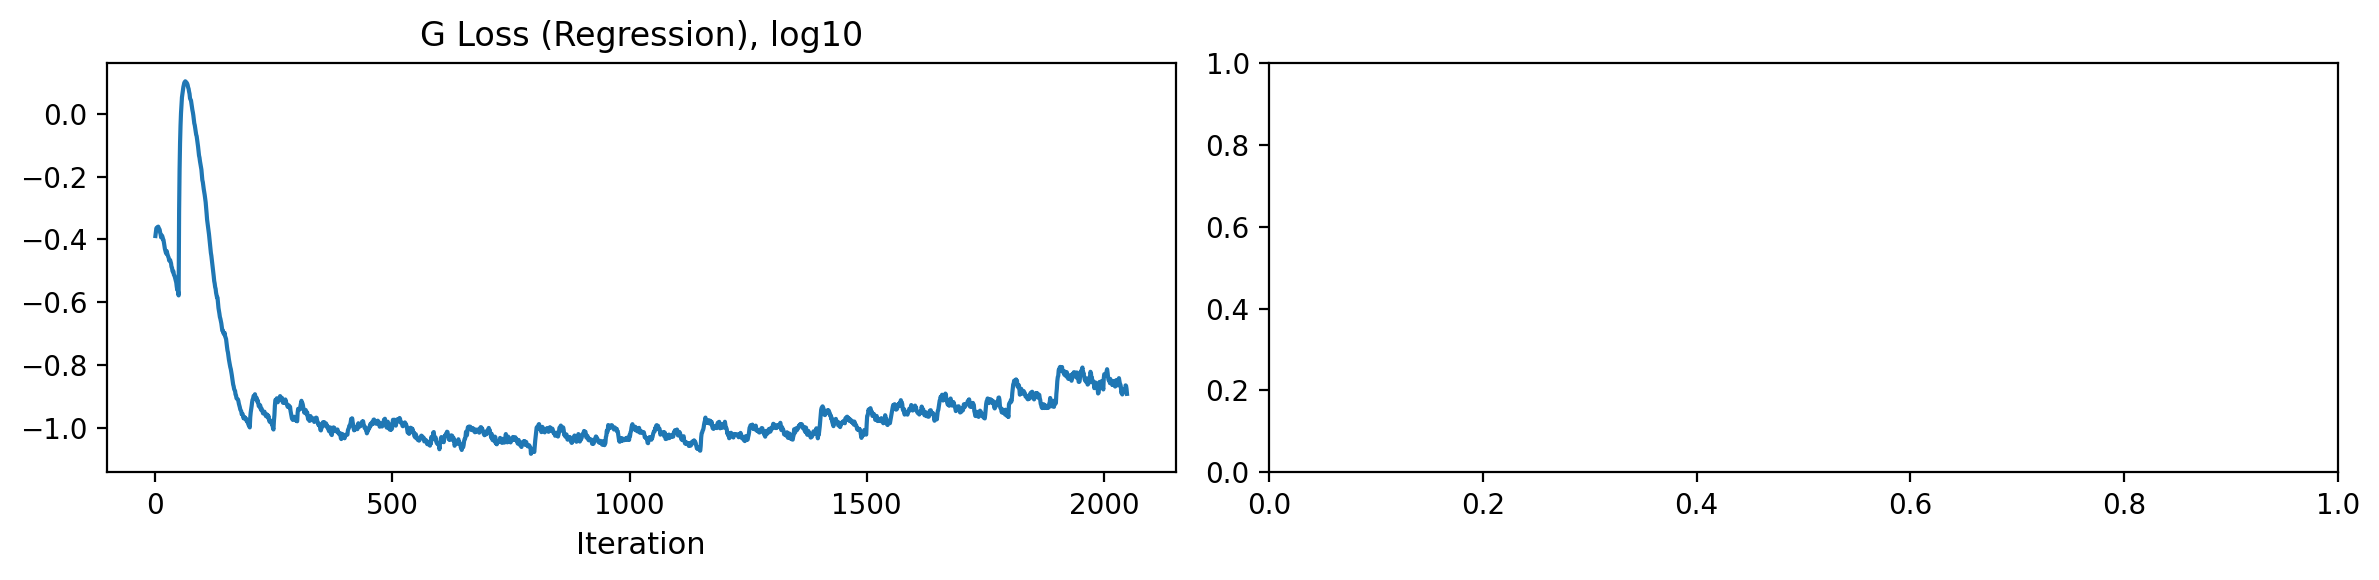

plt!!!!!!!!


In [ ]:
# training: bad initialization
MAX_ITER = 200000

# joint training T, then train the network distributedly
BATCH_SIZE = 64
BATCH_SIZE_G = 128

D_ITERS = 50
T_ITERS = 10
G_ITERS = 50

# Main Training Loop
it = 0 # number of iterations
G_time = 0 # numbers of G updating
loss_at_start = 0
start_losses = [] # a list of the first G_losses after updating T
W2_dis_bad = []

while it < MAX_ITER:
    
    G_time += 1

    # Optimize T and D
    it = optimize_T_and_D_UOT_new(it, G, T, D, T_opt, D_opt, Z_sampler, gmm_samplers, n_mixtures, DIM, BATCH_SIZE, 
                              ALPHAS_LF, D_ITERS, T_ITERS, tau=1)
    # it = optimize_T_and_D(it, G, T, D, T_opt, D_opt, Z_sampler, gmm_samplers, n_mixtures, DIM, BATCH_SIZE, 
    #                           ALPHAS_LF, D_ITERS, T_ITERS)

    loss_at_start = optimize_G(G, T, G_opt, Z_sampler, ALPHAS_LF, n_mixtures, DIM, G_ITERS, BATCH_SIZE_G, G_loss_history)
    start_losses.append(loss_at_start)

    # Plot metrics
    # Plotting
    if True:
        clear_output(wait=True)
        print('Iteration', it)

        # Plotting Metrics
        fig, axes = plt.subplots(1, 2, figsize=(12, 3), dpi=200)

        axes[0].set_title('G Loss (Regression), log10', fontsize=12)
        axes[0].set_xlabel('Iteration', fontsize=11)
        axes[0].plot(np.log10(ewma(G_loss_history, span=10)))

        fig.tight_layout(); plt.show(); plt.close(fig)

        print("plt!!!!!!!!")
    
    # Early stopping or checkpoint saving
    if G_time > 40:
        break

You can save the learned unbalanced barycenters/maps. To compute the classical OT barycenter, repeat the process using the `optimize_T_and_D` function.

In [ ]:
# save_path = "/Path/to/your/folder"
# torch.save(G.state_dict(), save_path+'/G_10_ub_40.pth')

# torch.save(T.state_dict(), save_path+'/T_10_ub_40.pth')
# torch.save(D.state_dict(), save_path+'/D_10_ub_40.pth')

In [ ]:
# save_path = "/Path/to/your/folder"
# torch.save(G.state_dict(), save_path+'/G_10_b_40.pth')

# torch.save(T.state_dict(), save_path+'/T_10_b_40.pth')
# torch.save(D.state_dict(), save_path+'/D_10_b_40.pth')

In [11]:
# G without pretraining
G_ub = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

# T/D setup
D_ub = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
D_ub.apply(weights_init)

# Seperate T
T_ub = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
T_ub.apply(weights_init)

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
G_ub.load_state_dict(torch.load(result_folder+'results/simu/outliernew/G_10_ub_40.pth'))
T_ub.load_state_dict(torch.load(result_folder+'results/simu/outliernew/T_10_ub_40.pth'))
D_ub.load_state_dict(torch.load(result_folder+'results/simu/outliernew/D_10_ub_40.pth'))

<All keys matched successfully>

In [12]:
# G without pretraining
G_b = Gnet(input_dim=input_dim, output_dim=DIM, size=size, num_layers=num_layers, dropout_rate=dropout_rate)

# T/D setup
D_b = Seperate_D(input_size, task_specific_hidden_size_D, n_hidden, n_outputs, bn, dropout_rate)
D_b.apply(weights_init)

# Seperate T
T_b = Seperate_T(input_size, task_specific_hidden_size_T, n_hidden, n_outputs, output_size, bn, dropout_rate)
T_b.apply(weights_init)

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
G_b.load_state_dict(torch.load(result_folder+'results/simu/outliernew/G_10_b_40.pth'))
T_b.load_state_dict(torch.load(result_folder+'results/simu/outliernew/T_10_b_40.pth'))
D_b.load_state_dict(torch.load(result_folder+'results/simu/outliernew/D_10_b_40.pth'))

<All keys matched successfully>

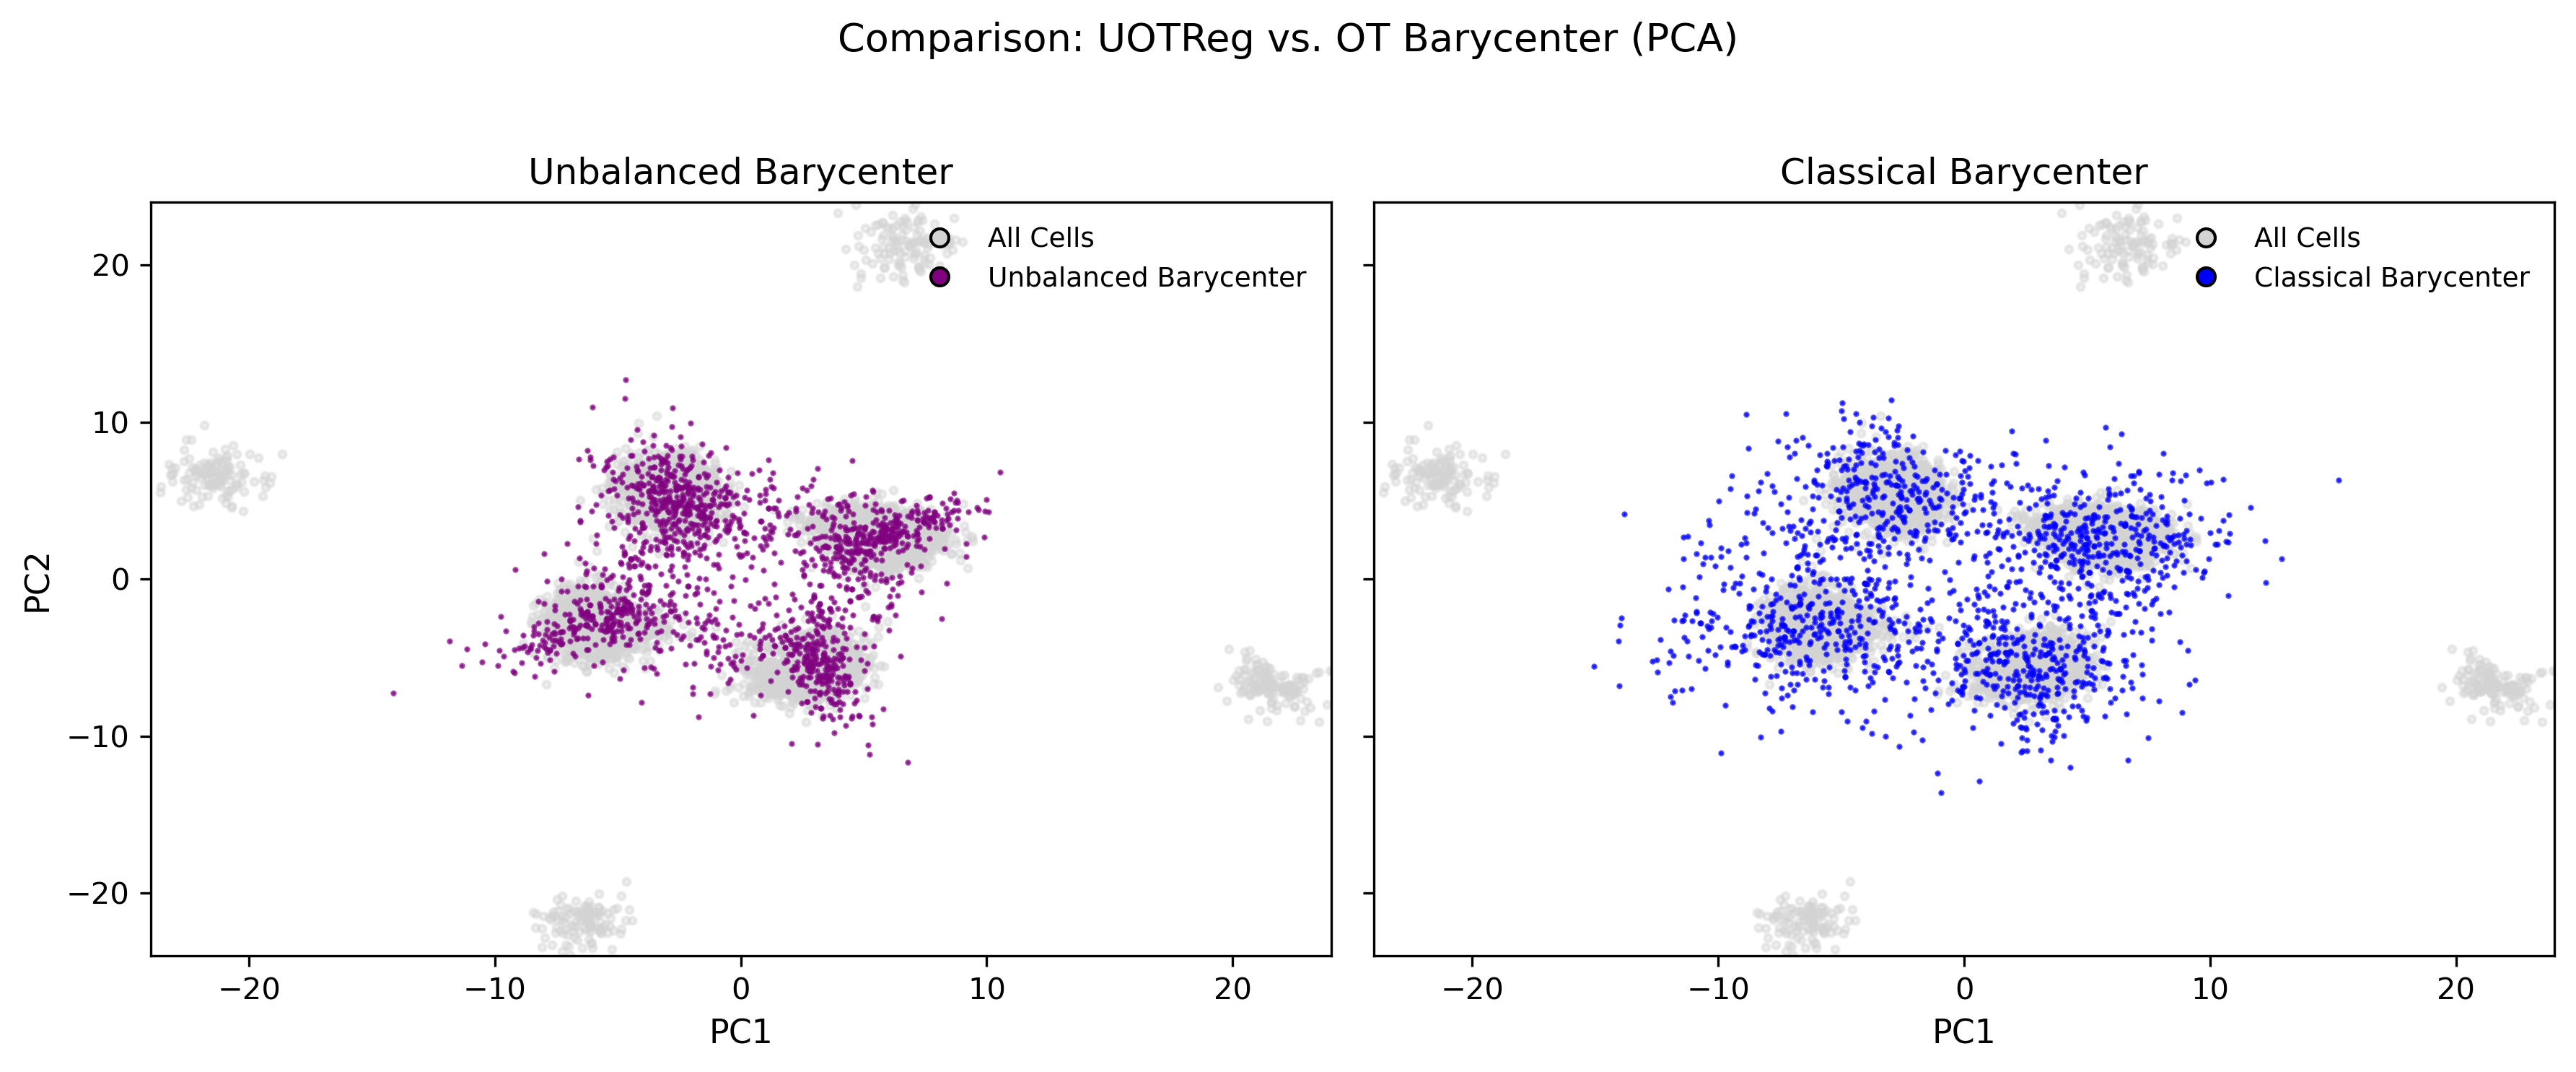

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import numpy as np

# Sample from generators
X_ub = G_ub(Z_sampler.sample(1600)).detach().numpy()   # Unbalanced barycenter
X_b = G_b(Z_sampler.sample(1600)).detach().numpy()     # Classical barycenter

# Subsample 20% of full dataset
np.random.seed(42)
n_total = X_all.shape[0]
n_sample = int(0.4 * n_total)
subset_indices = np.random.choice(n_total, size=n_sample, replace=False)
X_all_sub = X_all[subset_indices]

# Fit PCA on combined data
pca = PCA(n_components=2)
pca.fit(np.vstack([X_all_sub, X_ub, X_b]))

X_all_pca = pca.transform(X_all_sub)
X_ub_pca = pca.transform(X_ub)
X_b_pca = pca.transform(X_b)

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=300, sharex=True, sharey=True)

# Axis limits
x_min, x_max = -24, 24
y_min, y_max = -24, 24

# Define consistent styling
bg_kwargs = dict(color="lightgrey", alpha=0.4, s=6)
ub_kwargs = dict(color="purple", alpha=0.7, s=1)
b_kwargs  = dict(color="blue", alpha=0.7, s=1)

# Define legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markersize=6, label='All Cells'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='purple', markersize=6, label='Unbalanced Barycenter'),
    Line2D([0], [0], marker='o', color='none', markerfacecolor='blue', markersize=6, label='Classical Barycenter'),
]

# Plot Unbalanced Barycenter
axes[0].scatter(X_all_pca[:, 0], X_all_pca[:, 1], **bg_kwargs)
axes[0].scatter(X_ub_pca[:, 0], X_ub_pca[:, 1], **ub_kwargs)
axes[0].set_title("Unbalanced Barycenter", fontsize=12)
axes[0].set_xlabel("PC1", fontsize=11)
axes[0].set_ylabel("PC2", fontsize=11)
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].tick_params(labelsize=10)
axes[0].legend(handles=legend_elements[:2], fontsize=9, loc="upper right", frameon=False)

# Plot Classical Barycenter
axes[1].scatter(X_all_pca[:, 0], X_all_pca[:, 1], **bg_kwargs)
axes[1].scatter(X_b_pca[:, 0], X_b_pca[:, 1], **b_kwargs)
axes[1].set_title("Classical Barycenter", fontsize=12)
axes[1].set_xlabel("PC1", fontsize=11)
axes[1].tick_params(labelsize=10)
axes[1].legend(handles=[legend_elements[0], legend_elements[2]], fontsize=9, loc="upper right", frameon=False)

# Global title and layout
fig.suptitle("Comparison: UOTReg vs. OT Barycenter (PCA)", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


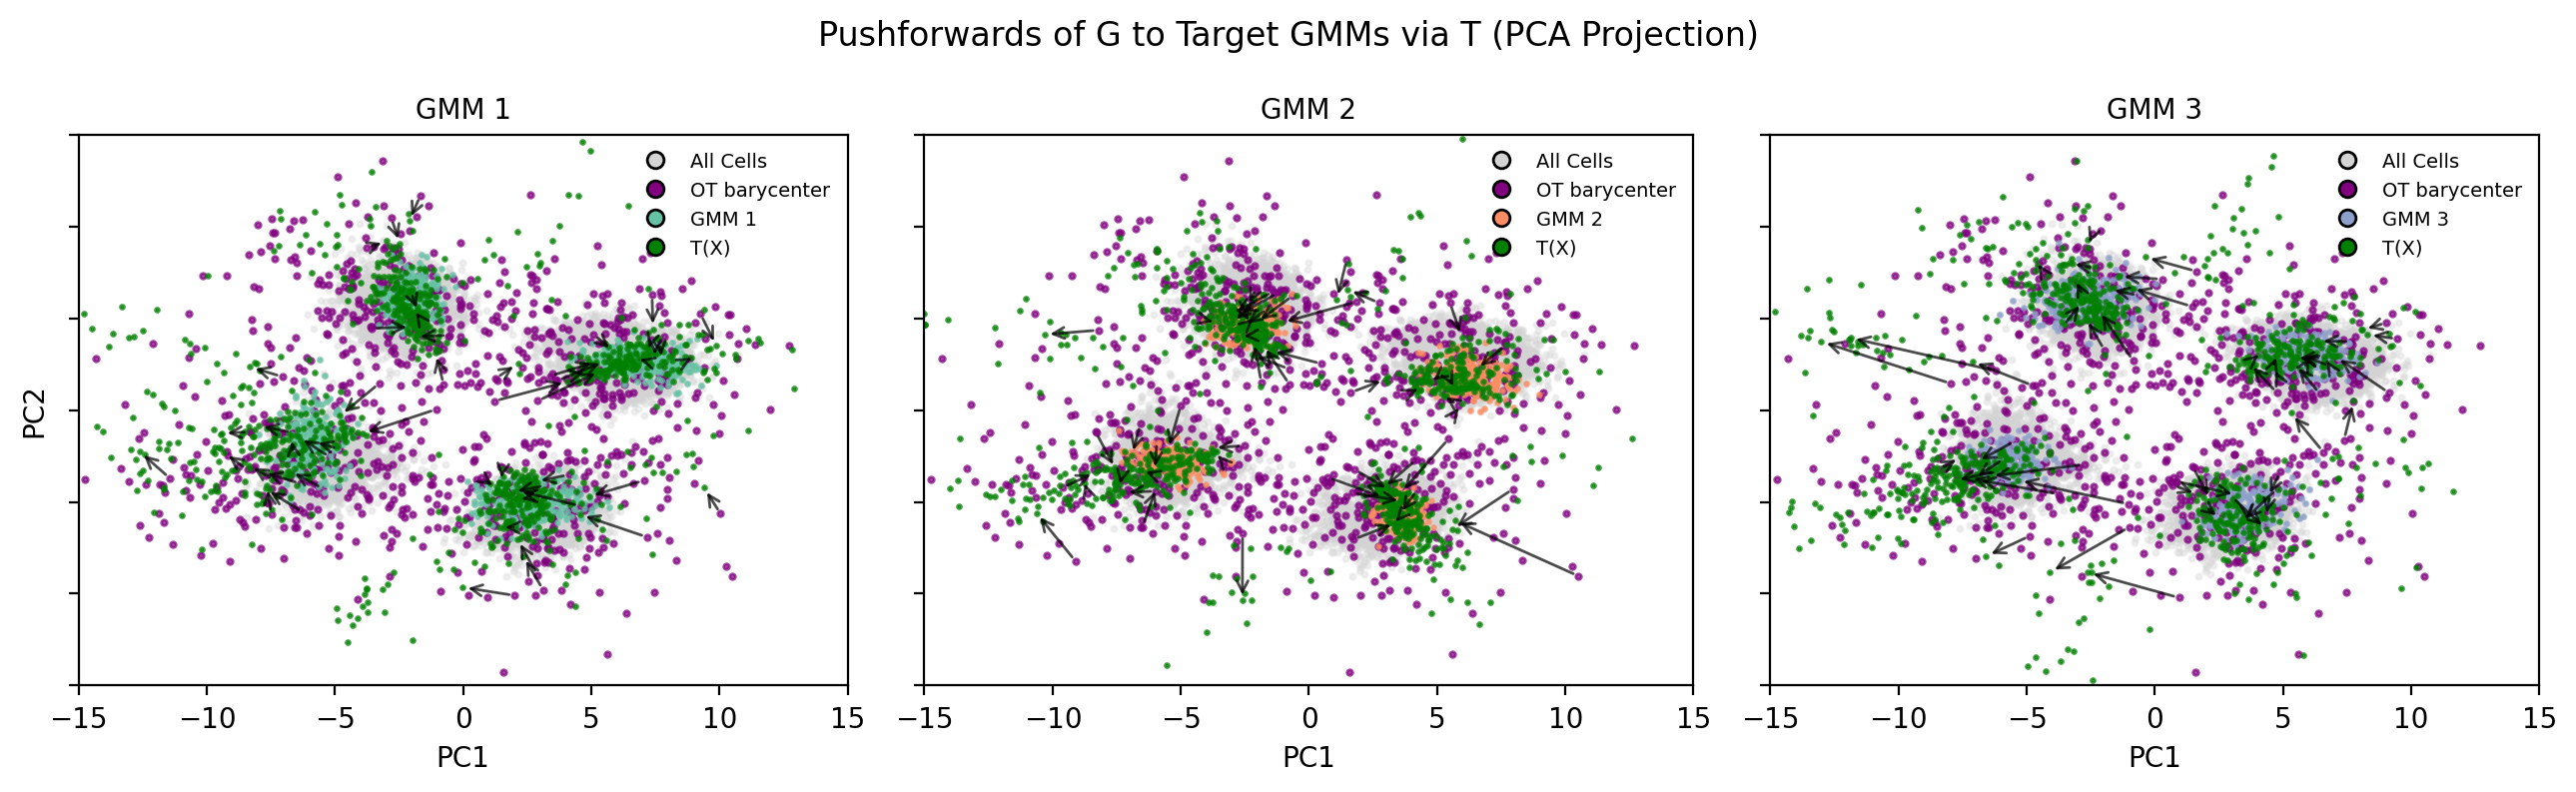

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

# Step 1: Get samples and push-forwards
with torch.no_grad():
    X = G_b(Z_sampler.sample(1000)).detach().numpy()  # (n, d)
    TX = T_b(torch.tensor(X)).detach().numpy()    # (n, d × m)

# Step 2: Select 3 GMMs
np.random.seed(0)
selected_indices = [2, 3, 4]
dataset_labels = [f"GMM {i-1}" for i in selected_indices]
colors = sns.color_palette("Set2", len(selected_indices))

# Step 3: Flatten pushforwards and fit PCA
gmm_all = np.vstack(all_data)  # (total_samples, d)
d = X.shape[1]
m = TX.shape[1] // d
TX_reshaped = TX.reshape(-1, d)  # (n * m, d)
pca_data = np.vstack([gmm_all, X, TX_reshaped])

pca = PCA(n_components=2)
pca.fit(pca_data)

X_pca = pca.transform(X)

# Step 4: Plot
fig, axes = plt.subplots(1, 3, figsize=(13, 4), dpi=200, sharex=True, sharey=True)

for plot_i, ax in enumerate(axes):
    idx = selected_indices[plot_i]

    # (a) Subsample 1000 target points
    X_i_full = all_data[idx]
    subset_idx = np.random.choice(X_i_full.shape[0], size=1000, replace=False)
    X_i = X_i_full[subset_idx]
    X_i_pca = pca.transform(X_i)

    # (b) Get corresponding pushforward
    TX_i = TX[:, idx * d : (idx + 1) * d]
    TX_i_pca = pca.transform(TX_i)

    # (c) Plot background
    gmm_all_pca = pca.transform(gmm_all)
    ax.scatter(gmm_all_pca[:, 0], gmm_all_pca[:, 1], color='lightgrey', alpha=0.3, s=4, label="All Cells")

    # (d) Plot G
    ax.scatter(X_pca[:, 0], X_pca[:, 1], color='purple', alpha=0.7, s=4, label="G")

    # (e) Plot target GMM
    ax.scatter(X_i_pca[:, 0], X_i_pca[:, 1], color=colors[plot_i], alpha=0.7, s=2, label=f"GMM {idx}")

    # (f) Plot pushforwarded G
    ax.scatter(TX_i_pca[:, 0], TX_i_pca[:, 1], color='green', alpha=0.7, s=2, label="T(G)")

    # (g) Draw arrows for 50 matched samples
    arrow_indices = np.random.choice(X.shape[0], size=50, replace=False)
    for i in arrow_indices:
        x0, y0 = X_pca[i]
        x1, y1 = TX_i_pca[i]
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1, alpha=0.7))

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)

    ax.set_title(dataset_labels[plot_i], fontsize=10)
    ax.set_xlabel("PC1")
    if plot_i == 0:
        ax.set_ylabel("PC2")
    else:
        ax.set_yticklabels([])

    # Shared Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markersize=6, label='All Cells'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='purple', markersize=6, label='OT barycenter'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[plot_i], markersize=6, label=f'GMM {idx-1}'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='green', markersize=6, label='T(X)'),
    ]
    ax.legend(handles=legend_elements, fontsize=7, loc='upper right', frameon=False)

# Final layout
fig.suptitle("Pushforwards of G to Target GMMs via T (PCA Projection)", fontsize=12)
plt.tight_layout()
plt.show()


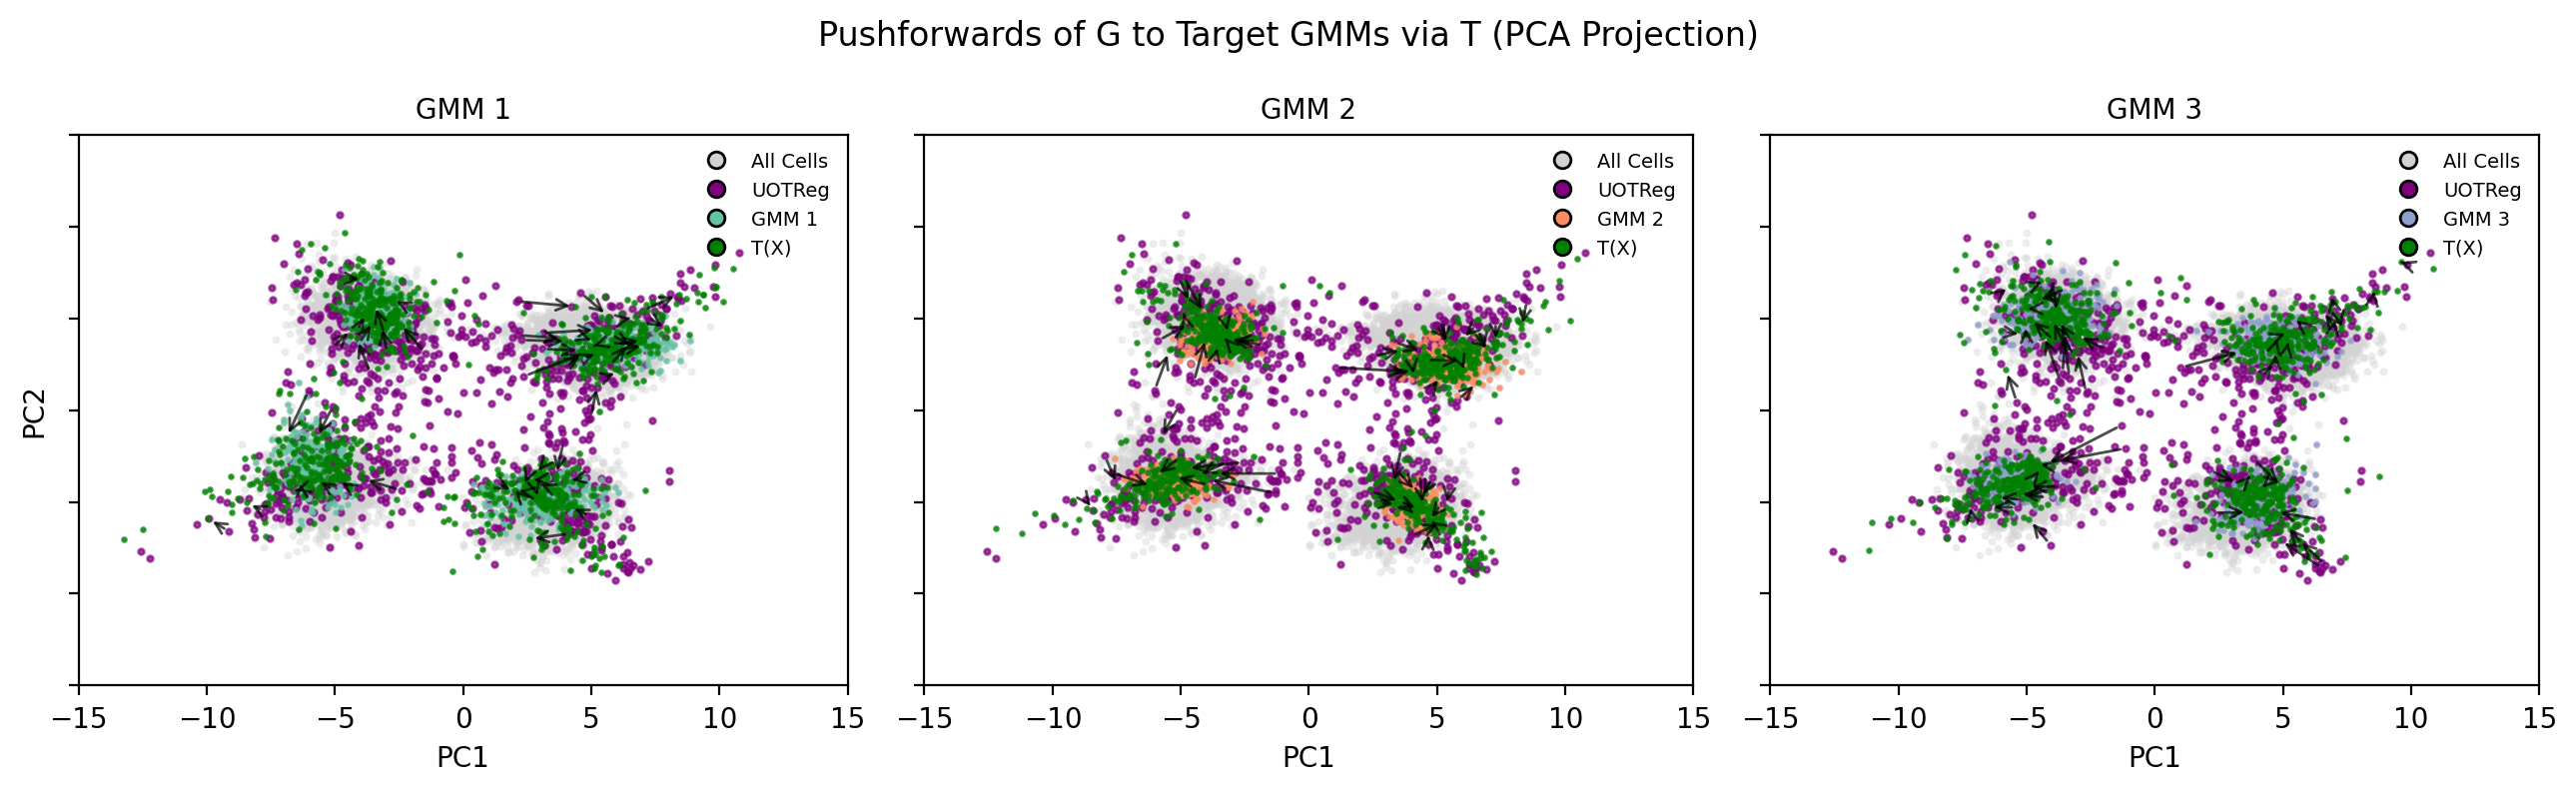

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

# Step 1: Get samples and push-forwards
with torch.no_grad():
    X = G_ub(Z_sampler.sample(1000)).detach().numpy()  # (n, d)
    TX = T_ub(torch.tensor(X)).detach().numpy()    # (n, d × m)

# Step 2: Select 3 GMMs
np.random.seed(0)
selected_indices = [2, 3, 4]
dataset_labels = [f"GMM {i-1}" for i in selected_indices]
colors = sns.color_palette("Set2", len(selected_indices))

# Step 3: Flatten pushforwards and fit PCA
gmm_all = np.vstack(all_data)  # (total_samples, d)
d = X.shape[1]
m = TX.shape[1] // d
TX_reshaped = TX.reshape(-1, d)  # (n * m, d)
pca_data = np.vstack([gmm_all, X, TX_reshaped])

pca = PCA(n_components=2)
pca.fit(pca_data)

X_pca = pca.transform(X)

# Step 4: Plot
fig, axes = plt.subplots(1, 3, figsize=(13, 4), dpi=200, sharex=True, sharey=True)

for plot_i, ax in enumerate(axes):
    idx = selected_indices[plot_i]

    # (a) Subsample 1000 target points
    X_i_full = all_data[idx]
    subset_idx = np.random.choice(X_i_full.shape[0], size=1000, replace=False)
    X_i = X_i_full[subset_idx]
    X_i_pca = pca.transform(X_i)

    # (b) Get corresponding pushforward
    TX_i = TX[:, idx * d : (idx + 1) * d]
    TX_i_pca = pca.transform(TX_i)

    # (c) Plot background
    gmm_all_pca = pca.transform(gmm_all)
    ax.scatter(gmm_all_pca[:, 0], gmm_all_pca[:, 1], color='lightgrey', alpha=0.3, s=4, label="All Cells")

    # (d) Plot G
    ax.scatter(X_pca[:, 0], X_pca[:, 1], color='purple', alpha=0.7, s=4, label="G")

    # (e) Plot target GMM
    ax.scatter(X_i_pca[:, 0], X_i_pca[:, 1], color=colors[plot_i], alpha=0.7, s=2, label=f"GMM {idx}")

    # (f) Plot pushforwarded G
    ax.scatter(TX_i_pca[:, 0], TX_i_pca[:, 1], color='green', alpha=0.7, s=2, label="T(G)")

    # (g) Draw arrows for 50 matched samples
    arrow_indices = np.random.choice(X.shape[0], size=50, replace=False)
    for i in arrow_indices:
        x0, y0 = X_pca[i]
        x1, y1 = TX_i_pca[i]
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1, alpha=0.7))

    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)

    ax.set_title(dataset_labels[plot_i], fontsize=10)
    ax.set_xlabel("PC1")
    if plot_i == 0:
        ax.set_ylabel("PC2")
    else:
        ax.set_yticklabels([])

    # Shared Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', markerfacecolor='lightgrey', markersize=6, label='All Cells'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='purple', markersize=6, label='UOTReg'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor=colors[plot_i], markersize=6, label=f'GMM {idx-1}'),
        Line2D([0], [0], marker='o', color='none', markerfacecolor='green', markersize=6, label='T(X)'),
    ]
    ax.legend(handles=legend_elements, fontsize=7, loc='upper right', frameon=False)

# Final layout
fig.suptitle("Pushforwards of G to Target GMMs via T (PCA Projection)", fontsize=12)
plt.tight_layout()
plt.show()
